In [8]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [9]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import random
import shutil
import torch
from typing import Any
import yaml
from rdkit import RDLogger
from generator import Generator
from language import Language, MolLanguage
from node import SurrogateNode, SentenceNode, MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def read_yaml(yaml_path: str) -> tuple[Generator, dict[str, Any]]:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)

    if "seed" in conf:
        seed = conf["seed"]
        random.seed(0)
        np.random.seed(0)
        torch.manual_seed(seed)

    generator_args = conf.get("generator_args", {})

    transition_args = conf.get("transition_args", {})
    if "model_dir" in transition_args:
        transition_args["model_dir"] = os.path.join(repo_root, transition_args["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_args["model_dir"])) + ".lang"
        lang_path = add_sep(transition_args["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_args)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_args", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_args", {}))
        generator_args["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))

    if "node_class" in conf:
        node_class = class_from_package("node", conf.get("node_class"))
    elif issubclass(lang.__class__, MolLanguage):
        node_class = MolSentenceNode
    elif issubclass(lang.__class__, Language):
        node_class = SentenceNode
    if node_class == MolSentenceNode:
        MolSentenceNode.use_canonical_smiles_as_key = conf.get("use_canonical_smiles_as_key", True)
   
    if type(conf.get("root")) == list:
        root = SurrogateNode()
        for s in conf.get("root"):
            node = node_class.node_from_key(lang=lang, string=s, device=conf.get("device"))
            root.add_child(action=s, child=node)
    else:
        root = node_class.node_from_key(lang=lang, string=conf.get("root", ""), device=conf.get("device"))
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, output_dir=output_dir, logger=logger, **generator_args)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.7781, node: COC(=O)c1ccc(Cl)c(NC(=O)c2cc(C)n(-c3ccc(Cl)cc3)c2C)c1
<best reward updated> order: 68, time: 0.78, reward: 0.7916, node: O=C(Oc1ccc(Cl)cc1Cl)c1ccccc1NC(=O)c1ccccc1F
generated: 100, time: 1.13, average over 100: 0.1305
generated: 200, time: 2.40, average over 100: 0.3192
<best reward updated> order: 227, time: 2.69, reward: 0.7972, node: O=C(/C=C\Cl)Sc1ccc(Cl)s1
<best reward updated> order: 254, time: 2.99, reward: 0.8382, node: O=C(/C=C/CC1CCCC1)Nc1nnc(C2CCC2)s1
generated: 300, time: 3.55, average over 100: 0.3725
<best reward updated> order: 363, time: 4.23, reward: 0.9508, node: O=C(/C=C\Cl)OCC#CCCO
generated: 400, time: 4.55, average over 100: 0.3233
<best reward updated> order: 443, time: 4.90, reward: 0.9513, node: O=C(/C=C\Cl)OCCO
generated: 500, time: 5.38, average over 100: 0.3950
<best reward updated> order: 513, time: 5.48, reward: 0.9532, node: O=C(/C=C\Cl)OCOCC(F)(F)F
<best reward updat

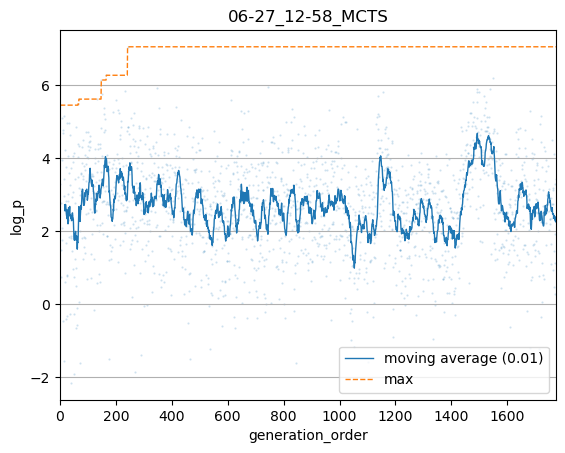

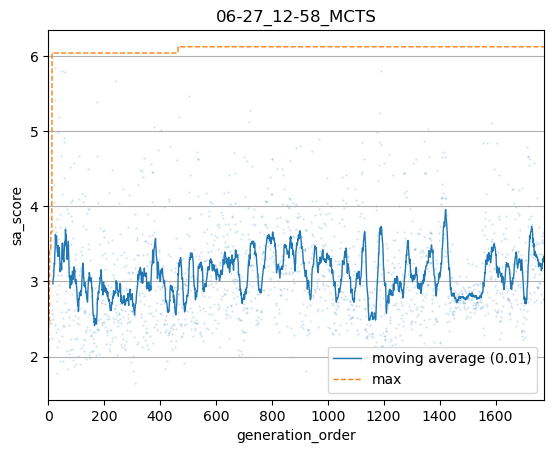

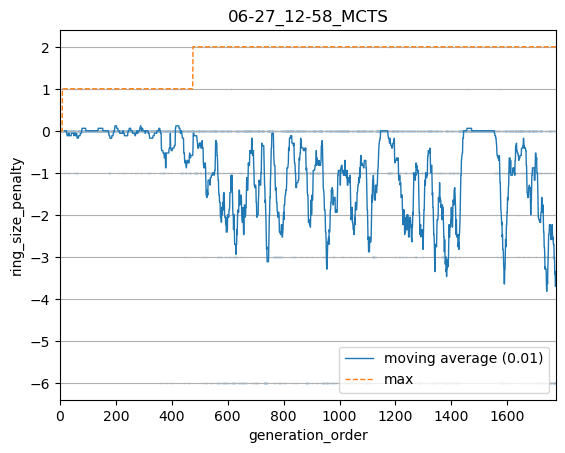

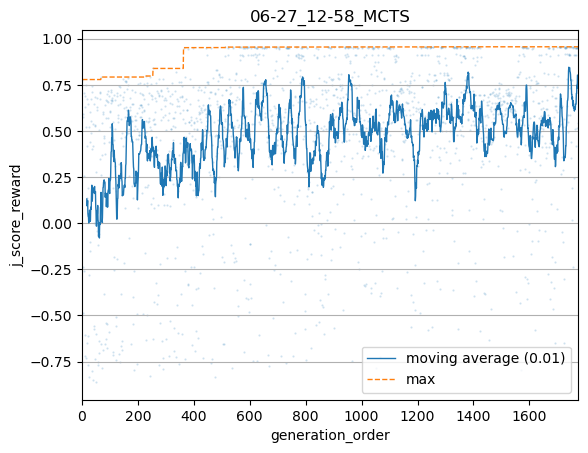

number of generated nodes: 1774
valid rate: 0.8849235251274581
unique rate: 0.7611070648215587
node_per_sec: 88.65729792755288
best_reward: 0.9555183849192699
average_reward: 0.46817672498554236


In [12]:
# start generation
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score.yaml"
c6 = "config/mcts_j_score.yaml"
generator, conf = read_yaml(c3)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts
load_dir = "generation_result/06-26_08-51/"
generator, conf = read_yaml("sandbox/" + load_dir + "setting.yaml")
generator = Generator.load(load_dir + "save.mcts", generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)

In [222]:
#DScore test
from reward import DScoreReward
from node import MolSentenceNode
cf = "config/mcts_d_score.yaml"
generator, conf = read_yaml(cf)
string = "c1sc2ncncc2c1[C@@H](O)c1=nc(C([O-])=O)=nc(N)=n1"
x = MolSentenceNode.node_from_string(lang=generator.transition.lang, string=string, include_eos=True, device="cpu")
generator.reward.objective_values_and_reward(x)

([7.738178695018596,
  5.380680492166317,
  4.343190079318335,
  4.663313149682271,
  5.224851127291654,
  4.654329008014571,
  4.843767364097564,
  4.935388081712041,
  5.2351610291927955,
  -2.3846970086718144,
  0.991810044601756,
  63.55878775057214,
  2.521272632444819,
  3.9831675518469654,
  0.6139719804089897,
  303.283,
  1,
  1],
 0.6487755981901583)

In [223]:
string = "c1sc2ncncc2c1"
y = MolSentenceNode.node_from_string(lang=generator.transition.lang, string=string, include_eos=False, device="cpu")
t = generator.transition.transitions_with_probs(y)
for action, node, prob in t:
    print(node, prob)

c1sc2ncncc2c1- 0.055533841252326965
c1sc2ncncc2c1/ 0.028348693624138832
c1sc2ncncc2c1 0.06410867720842361
c1sc2ncncc2c1C 0.4694652259349823
c1sc2ncncc2c1F 0.0009618543554097414
c1sc2ncncc2c1I 0.0021593605633825064
c1sc2ncncc2c1N 0.19565324485301971
c1sc2ncncc2c1O 0.017446408048272133
c1sc2ncncc2c1S 0.007149592507630587
c1sc2ncncc2c1[C@@H] 0.06944021582603455
c1sc2ncncc2c1[C@@] 0.002234969986602664
c1sc2ncncc2c1[C@H] 0.05132880061864853
c1sc2ncncc2c1[C@] 0.0014879098162055016
c1sc2ncncc2c1[N-] 0.004273803438991308
c1sc2ncncc2c1[O-] 0.012141085229814053
c1sc2ncncc2c1c 0.013975519686937332
c1sc2ncncc2c1n 0.004290837794542313


In [8]:
#JScore test
from reward import DScoreReward
from node import MolSentenceNode
cf = "config/mcts_j_score.yaml"
generator, conf = read_yaml(cf)
string = "O=C(Nc1cc(Nc2c(Cl)cccc2NCc2ccc(Cl)cc2Cl)ccc1C1=CCCCC1)c1cc(F)cc(Cl)c1"
x = MolSentenceNode.node_from_string(lang=generator.transition.lang, string=string, include_eos=True, device="cpu")
generator.reward.objective_values_and_reward(x)

([11.004699999999985, 2.7979856545812734, 0], 0.8645154119818951)